# 1. Load images

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

sample_dataset = datasets.ImageFolder(root="test_samples/",
                                      transform=data_transform)

dataset_loader = torch.utils.data.DataLoader(sample_dataset,
                                             batch_size=1, 
                                             shuffle=False,
                                             num_workers=0)

print(f"{len(dataset_loader)} images are loaded.")

4 images are loaded.


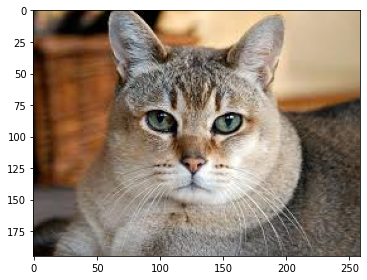

In [2]:
img = sample_dataset.imgs[0][0]
img = Image.open(img)
plt.imshow(img)
plt.tight_layout()

# 2. Set up the Pytorch hook

In [3]:
model_name = "resnet18"
model = torch.hub.load("pytorch/vision:v0.6.0", model_name, pretrained=True)
model = model.to("cpu")
print(f"Pre-trained model: {model_name}")

layer = model._modules.get("avgpool")
print(f"Embedding layer: {layer}")

vec_size = model._modules.get("fc").in_features
print(f"Embedding vector size: {vec_size}")

def get_vector(input_image):
    # 1. read the image
    image = input_image.to("cpu")
    
    # 2. Set the hook on one layer
    vec = torch.zeros(1, vec_size, 1, 1)
    def hook_fn(layer, input, output):
        vec.copy_(output.data)
    hook = layer.register_forward_hook(hook_fn)
    
    # 3. pass the image through the nn
    model.eval()
    model(image)
    
    # 4. remove the hook
    hook.remove()
    
    return vec.numpy()[0, :, 0, 0].reshape(-1, 1).T

Using cache found in /Users/chjin/.cache/torch/hub/pytorch_vision_v0.6.0


Pre-trained model: resnet18
Embedding layer: AdaptiveAvgPool2d(output_size=(1, 1))
Embedding vector size: 512


# 3. Construct the embeddings

In [4]:
import pandas as pd

vec_dict = {}
for i, image in enumerate(dataset_loader):
    vec = get_vector(image[0])[0]
    vec_dict[i] = vec
    
vec_df = pd.DataFrame.from_dict(vec_dict, orient="index")
vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.135172,0.716481,1.174602,1.147072,0.327893,0.168616,0.079528,0.192818,1.079008,0.411938,...,1.652528,0.442316,0.320819,1.651349,2.083535,1.653737,1.417976,2.184484,0.288387,0.287859
1,1.847332,0.469702,1.503478,0.875133,0.232337,0.658844,0.573598,0.171017,1.146131,0.881035,...,0.949515,0.352137,0.169065,1.987912,1.533588,1.761491,1.240717,2.279284,0.382442,0.317243
2,0.995418,0.016639,1.275969,0.203276,0.021952,2.183850,1.213427,0.701680,1.470959,1.372498,...,0.616174,0.000000,0.492402,1.355833,0.409388,0.377772,0.554048,1.173599,0.050968,0.647039
3,2.177980,0.301247,0.149171,1.725657,0.759464,0.815213,0.035104,2.710513,0.410259,3.283305,...,0.807965,0.000000,2.256365,0.278504,1.836922,0.676436,0.123181,2.325945,1.943647,0.709217


# 4. Calculate the cosine similarity

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

sim_df = cosine_similarity(vec_df)
sim_df

array([[1.        , 0.79124219, 0.6562658 , 0.57666252],
       [0.79124219, 1.        , 0.81357486, 0.59977709],
       [0.6562658 , 0.81357486, 1.        , 0.60135802],
       [0.57666252, 0.59977709, 0.60135802, 1.        ]])

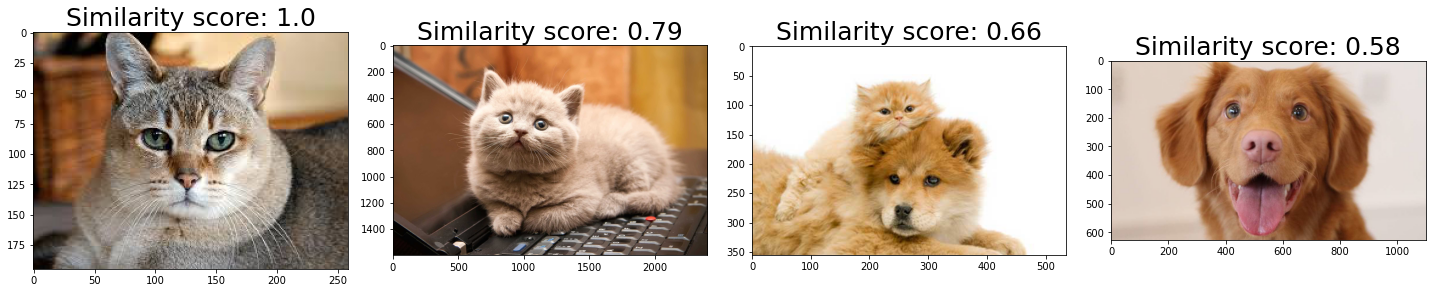

In [6]:
fig=plt.figure(figsize=(20, 10))
n_cols = len(sample_dataset.imgs)

for i, img in enumerate(sample_dataset.imgs):
    img = Image.open(img[0])
    fig.add_subplot(1, n_cols, i+1)
    plt.imshow(img)
    plt.title(f"Similarity score: {round(sim_df[0, :][i], 2)}", fontsize=25)
plt.tight_layout()

# Notes:
- Speed up the search using Approximate Nearest Neighbors algorithms, i.e. Spotify’s Annoy.